In [ ]:
import os
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
# please change the following path to where data store
path = r"/content/drive/MyDrive/Colab Notebooks/PDE_final_data"

##### **4. Testing of the model: Test in Monte Carlo Simulation**

In [ ]:
# 4.1 basic analytical formula for vanilla option and digital option
def eu(S,K,T,sigma,r,CorP=True):  # vanilla european option
    d1 = (np.log(S / K) + (r + 1 / 2 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sign = 1 if CorP else -1
    return sign*(S*norm.cdf(sign*d1)-K*np.exp(-r*T)*norm.cdf(sign*d2))

def digit(S,K,T,sigma,r,CorP=True): # Digital Option
    d1 = (np.log(S / K) + (r + 1 / 2 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sign = 1 if CorP else -1
    return np.exp(-r*T)*norm.cdf(sign*d2)

def eu_delta(S,K,T,sigma,r,CorP=True):  # vanilla european option delta
    d1 = (np.log(S / K) + (r + 1 / 2 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    sign = 1 if CorP else -1
    return norm.cdf(sign*d1)

In [ ]:
# 4.2 stock path simulation
def generate_stock_path(S,T,sigma,r,freq):
    t = np.linspace(0,T,T*360*freq+1)
    W = np.random.normal(0,1/np.sqrt(360*freq),T*360*freq)
    W = np.cumsum(W)
    W = np.append(np.array([0]), W)
    S_path = S*np.exp((r-1/2*sigma**2)*t+sigma*W)
    return S_path
def Barrier(B,K,T,gamma,freq):
    t = np.linspace(0,T,T*360*freq+1)
    res = np.flip(B*np.exp(-gamma*t))
    res[-1] = K
    return res
def down_out_payoff(barrier,K,T,S_path,CorP=True):
    t = S_path.shape[0]
    flag = (S_path<barrier).any()
    if flag:
        payoff = 0
        default = 1
    else:
        payoff = np.exp(-r*T) * max(S_path[-1]-K,0) if CorP else max(K-mat[i,-1],0)
        default = 0
    return payoff, default

In [ ]:
# 4.3 analytical solution for moving barrier option and default probability
V, K, D, T, sigma, r, gamma = 60, 55, 55, 3, np.sqrt(360)*0.01318, 0.05, 0.1

def mdo(V,K,D,T,sigma,r,gamma):  # Equity Value: theoretical value of down-and-out call option with moving barrier
  a = -(r-gamma-0.5*sigma**2)/sigma**2
  return eu(V,D,T,sigma,r) - eu((K*np.exp(-gamma*T))**2/V,D,T,sigma,r) * (V/(K*np.exp(-gamma*T)))**(2*a)

def PD(V,K,D,T,sigma,r,gamma):  # Probability of Default: 1 - theoretical value of down-and-out digital call option with moving barrier
  a = -(r-gamma-0.5*sigma**2)/sigma**2
  return 1 - np.exp(r*T)* (digit(V,D,T,sigma,r) - digit((K*np.exp(-gamma*T))**2/V,D,T,sigma,r) * (V/(K*np.exp(-gamma*T)))**(2*a))

def mdo_delta(V,K,D,T,sigma,r,gamma):  # dE/dV
    a = -(r-gamma-0.5*sigma**2)/sigma**2
    vt = K*np.exp(-gamma*T)
    return eu_delta(V,D,T,sigma,r)-2*a/vt*((V/vt)**(2*a-1))*eu((K*np.exp(-gamma*T))**2/V,D,T,sigma,r)+\
           ((V/vt)**(2*a-2))*eu_delta((K*np.exp(-gamma*T))**2/V,D,T,sigma,r)

a = -(r-gamma-0.5*sigma**2)/sigma**2
Theo_price = mdo(V,K,D,T,sigma,r,gamma)
Theo_prob_default = PD(V,K,D,T,sigma,r,gamma)

In [ ]:
# 4.4 Monte Carlo simulation
freq = 100
num_trial = 10000

payoff_sum, default_times = 0, 0
for i in tqdm(range(num_trial)):
    S_path = generate_stock_path(V,T,sigma,r,freq)
    barrier = Barrier(K,D,T,gamma,freq)
    payoff, default = down_out_payoff(barrier,D,T,S_path)
    payoff_sum += payoff
    default_times += default
MC_price = payoff_sum / num_trial
MC_default_prob = default_times / num_trial

100%|██████████| 10000/10000 [02:20<00:00, 71.15it/s]


In [ ]:
# 4.5 check with Monte Carlo
print("Monte Carlo Price: {:.4f}; Theoretical Price: {:.4f}".format(MC_price, Theo_price))
print("Monte Carlo Prob_default: {:.4f}; Theoretical Prob_default: {:.4f}".format(MC_default_prob, Theo_prob_default))

Monte Carlo Price: 14.7241; Theoretical Price: 14.6684
Monte Carlo Prob_default: 0.5678; Theoretical Prob_default: 0.5691


In [ ]:
# 4.6 check extreme condition

def do_call(V,K,D,T,sigma,r):
  a = -1/2*(r/(1/2*sigma**2)-1)
  return eu(V,D,T,sigma,r)-(V/K)**(2*a)*eu(K**2/V,D,T,sigma,r)

K_1, D_1 = 1e-8, 1e-8
K_2, gamma_2 = 50, 0
print("1. Strike at 0: {:.4f}; V: {:.4f}".format(mdo(V,K_1,D_1,T,sigma,r,gamma), V))
print("2. Static Barrier: {:.4f}; down-and-out call: {:.4f}".format(mdo(V,K_2,D,T,sigma,r,gamma_2), do_call(V,K_2,D,T,sigma,r)))

1. Strike at 0: 60.0000; V: 60.0000
2. Static Barrier: 12.2603; down-and-out call: 12.2603


##### **5. Calibration: Example: Dentsply Sirona 1-Year Default Probability**

In [ ]:
# 5.1 read in data
# 5.1.1 quarterly Balance Sheet data from 03/31/16 to 05/12/22
BS = pd.read_csv(os.path.join(path, "XRAY_quarterly_balance-sheet.csv"), index_col=0)
Asset = BS.loc["TotalAssets"][:25]
Equity = BS.loc["TotalEquityGrossMinorityInterest"][:25]
D = BS["03/31/2022"]["TotalLiabilitiesNetMinorityInterest"]
C = BS["03/31/2022"]["\tCurrentLiabilities"]
# 5.1.2 daily quote price from 03/31/16 to 05/12/22
quote = pd.read_csv(os.path.join(path, "XRAY.csv"))
quote["return"] = quote["Adj Close"].pct_change()
# 5.1.3 10-year Treasury yield from 01/01/22 to 05/12/22
rf = pd.read_csv(os.path.join(path, "^TNX.csv"))
rf = rf["Adj Close"].mean()*0.01

In [ ]:
# 5.2 calculate equity volatility
# Method 1: standard deviation of quarterly equity
sigma_e_1 = 2*np.std(Equity/Equity.shift(-1)-1)
print("Volatility Method 1: ", sigma_e_1)

# Method 2: standard deviation of daily return (03/31/16 ~ 03/31/22)
sigma_e_2 = np.sqrt(252)*quote[quote["Date"]<="2022-03-31"]["return"].std()
print("Volatility Method 2: ", sigma_e_2)

# Method 3: standard deviation of daily return (03/31/22 ~ 05/12/22)
sigma_e_3 = np.sqrt(252)*quote[quote["Date"]>"2022-03-31"]["return"].std()
print("Volatility Method 3: ", sigma_e_3)

# Method 4: implied volatility of option (See XRAY_vix.xlsx for more details)
vix_june, vix_july = 0.235933178, 0.221560587
sigma_e_4 = np.sqrt((vix_june+vix_july)/2)
print("Volatility Method 4: ", sigma_e_4)

Volatility Method 1:  0.11804993389484673
Volatility Method 2:  0.30656631888524577
Volatility Method 3:  0.5064703066353624
Volatility Method 4:  0.47827490264491196


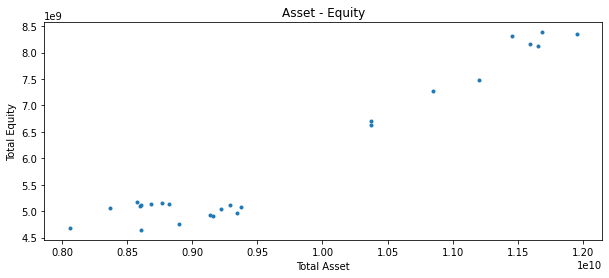

Historical Volatility of Company Value:  0.09051647732200913
OLS Regression Estimated Volatility:  0.25153906886125293
Option Delta Estimated Volatility:  0.2712601882481537


In [ ]:
# 5.3 calculate volatility of company value
# 5.3.1 Method 1: dE/dV = beta in OLS Regression (E = c + beta*V)
E, V = Equity[0], Asset[0]
sigma_v = 2*np.std(Asset/Asset.shift(-1)-1)  # initial volatility of V
plt.figure(figsize=(10, 4))
plt.plot(Asset, Equity, ".")
plt.xlabel("Total Asset")
plt.ylabel("Total Equity")
plt.title("Asset - Equity")
plt.show()
# Use beta of E to V as dE/dV (OLS Regression E ~ c + V)
X = sm.add_constant(Asset.values)
reg = sm.OLS(Equity.values, X)
res = reg.fit()
dE_dV = res.params[1]
sigma_v_1 = sigma_e_3*E/V/dE_dV
print("Historical Volatility of Company Value: ", sigma_v)
print("OLS Regression Estimated Volatility: ", sigma_v_1)

# 5.3.2 Method 2: dE/dV = option delta (use initial volatility)
FCF, Pay_Debt = 545000000, 299000000
T, Long_T = 1, D/(FCF+Pay_Debt)
K = C+(D-C)*np.exp(-rf*(Long_T-T))
sigma_v_2 = sigma_e_3*E/V/mdo_delta(V,K,K,T,sigma_v,rf,rf)
print("Option Delta Estimated Volatility: ", sigma_v_2)

In [ ]:
# 5.4 calculate probability of default within 1 year
FCF, Pay_Debt = 545000000, 299000000
T, Long_T = 1, D/(FCF+Pay_Debt)
K = C+(D-C)*np.exp(-rf*(Long_T-T))
pod_1y = PD(V,K,K,T,sigma_v_1,rf,rf)
print("Moody’s Idealized Cumulative Expected Default Rates (1 Year)")
print("Baa2: 0.1700%  Baa3: 0.4200%")
print("Probability of Default within 1 Year: {}%".format(round(pod_1y*100,4)))

Moody’s Idealized Cumulative Expected Default Rates (1 Year)
Baa2: 0.1700%  Baa3: 0.4200%
Probability of Default within 1 Year: 0.1411%
